In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import kstest, gennorm
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
wti = yf.download('CL=F', start='2000-01-01', end='2023-12-31')
wti['Date'] = pd.to_datetime(wti.index)
wti['Year'] = wti['Date'].dt.year
wti = wti.set_index('Date')   
wti['Daily_Return'] = wti['Adj Close'].pct_change()
wti['Log_Return'] = np.log(wti['Adj Close']).diff()

[*********************100%%**********************]  1 of 1 completed


In [3]:
wti.tail(10)

,Open,High,Low,Close,Adj Close,Volume,Year,Daily_Return,Log_Return
Date,,,,,,,,,
2023-12-15,71.610001,72.220001,70.300003,71.430000,71.430000,95513,2023,-0.002096,-0.002098
2023-12-18,71.680000,74.260002,70.639999,72.470001,72.470001,73941,2023,0.014560,0.014455
2023-12-19,72.480003,74.010002,71.849998,73.440002,73.440002,230042,2023,0.013385,0.013296
2023-12-20,74.059998,75.370003,73.599998,74.220001,74.220001,273364,2023,0.010621,0.010565
2023-12-21,73.809998,74.580002,72.440002,73.889999,73.889999,251982,2023,-0.004446,-0.004456
2023-12-22,73.910004,74.980003,73.389999,73.559998,73.559998,222600,2023,-0.004466,-0.004476
2023-12-26,73.559998,76.180000,73.129997,75.570000,75.570000,208715,2023,0.027325,0.026958
2023-12-27,75.320000,75.660004,73.769997,74.110001,74.110001,253323,2023,-0.019320,-0.019509
2023-12-28,73.800003,74.400002,71.720001,71.769997,71.769997,262748,2023,-0.031575,-0.032084


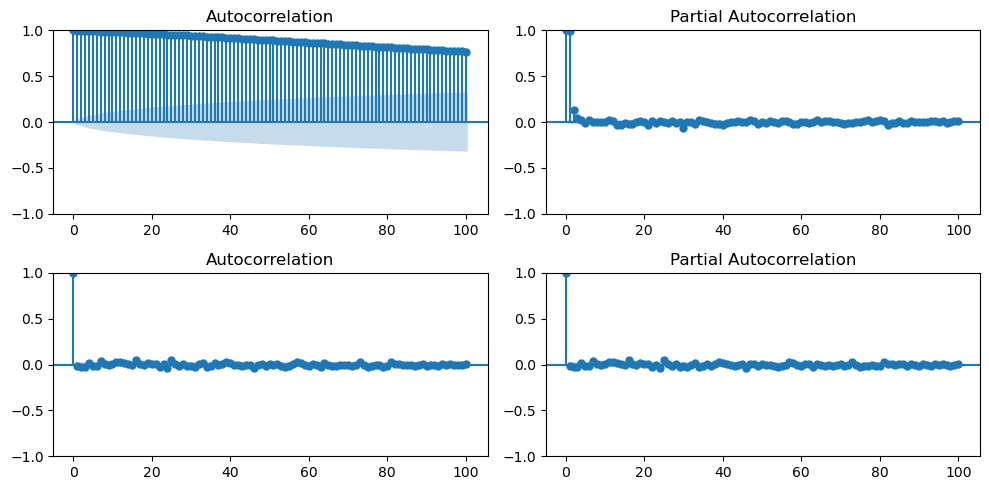

In [4]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
plot_acf(wti['Close'].dropna(), ax=axs[0,0], lags=100)
plot_pacf(wti['Close'].dropna(), ax=axs[0,1], lags=100)
plot_acf(wti['Log_Return'].dropna(), ax=axs[1,0], lags=100)
plot_pacf(wti['Log_Return'].dropna(), ax=axs[1,1], lags=100)
plt.tight_layout(); plt.show()

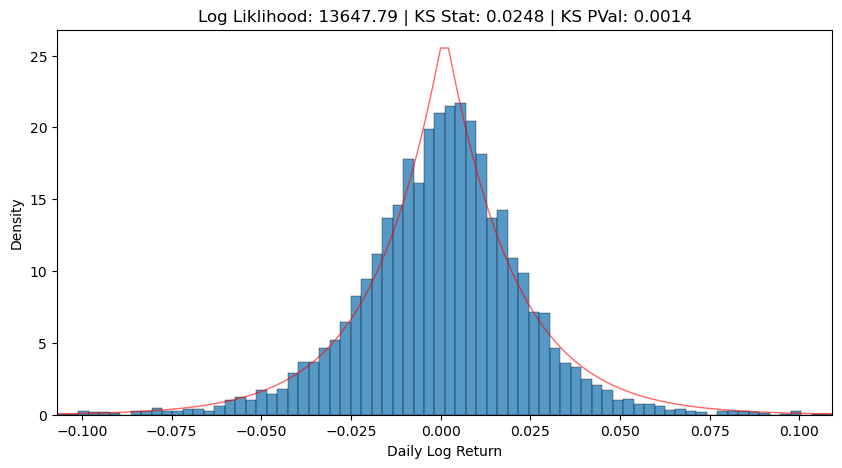

In [5]:
params = gennorm.fit(wti['Log_Return'].dropna())
log_likelihood = gennorm.logpdf(wti['Log_Return'].dropna(), *params).sum()
ks_stat, ks_stat_pval = kstest(wti['Log_Return'].dropna(), 'gennorm', params)

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(wti['Log_Return'].dropna(), kde=False, stat='density', ax=ax)
x = np.linspace(gennorm.ppf(0.001, params[0], params[1], params[2]), 
                    gennorm.ppf(0.999, params[0], params[1], params[2]), 
                    100)
ax.plot(x, gennorm.pdf(x, params[0], params[1], params[2]), 'r-', 
                lw=1, alpha=0.6, label='GED fit')
ax.set(title=f'Log Liklihood: {log_likelihood:.2f} | KS Stat: {ks_stat:.4f} | KS PVal: {ks_stat_pval:.4f}',
       xlabel='Daily Log Return', ylabel='Density', xlim=(np.min(x), np.max(x)))
plt.show()  

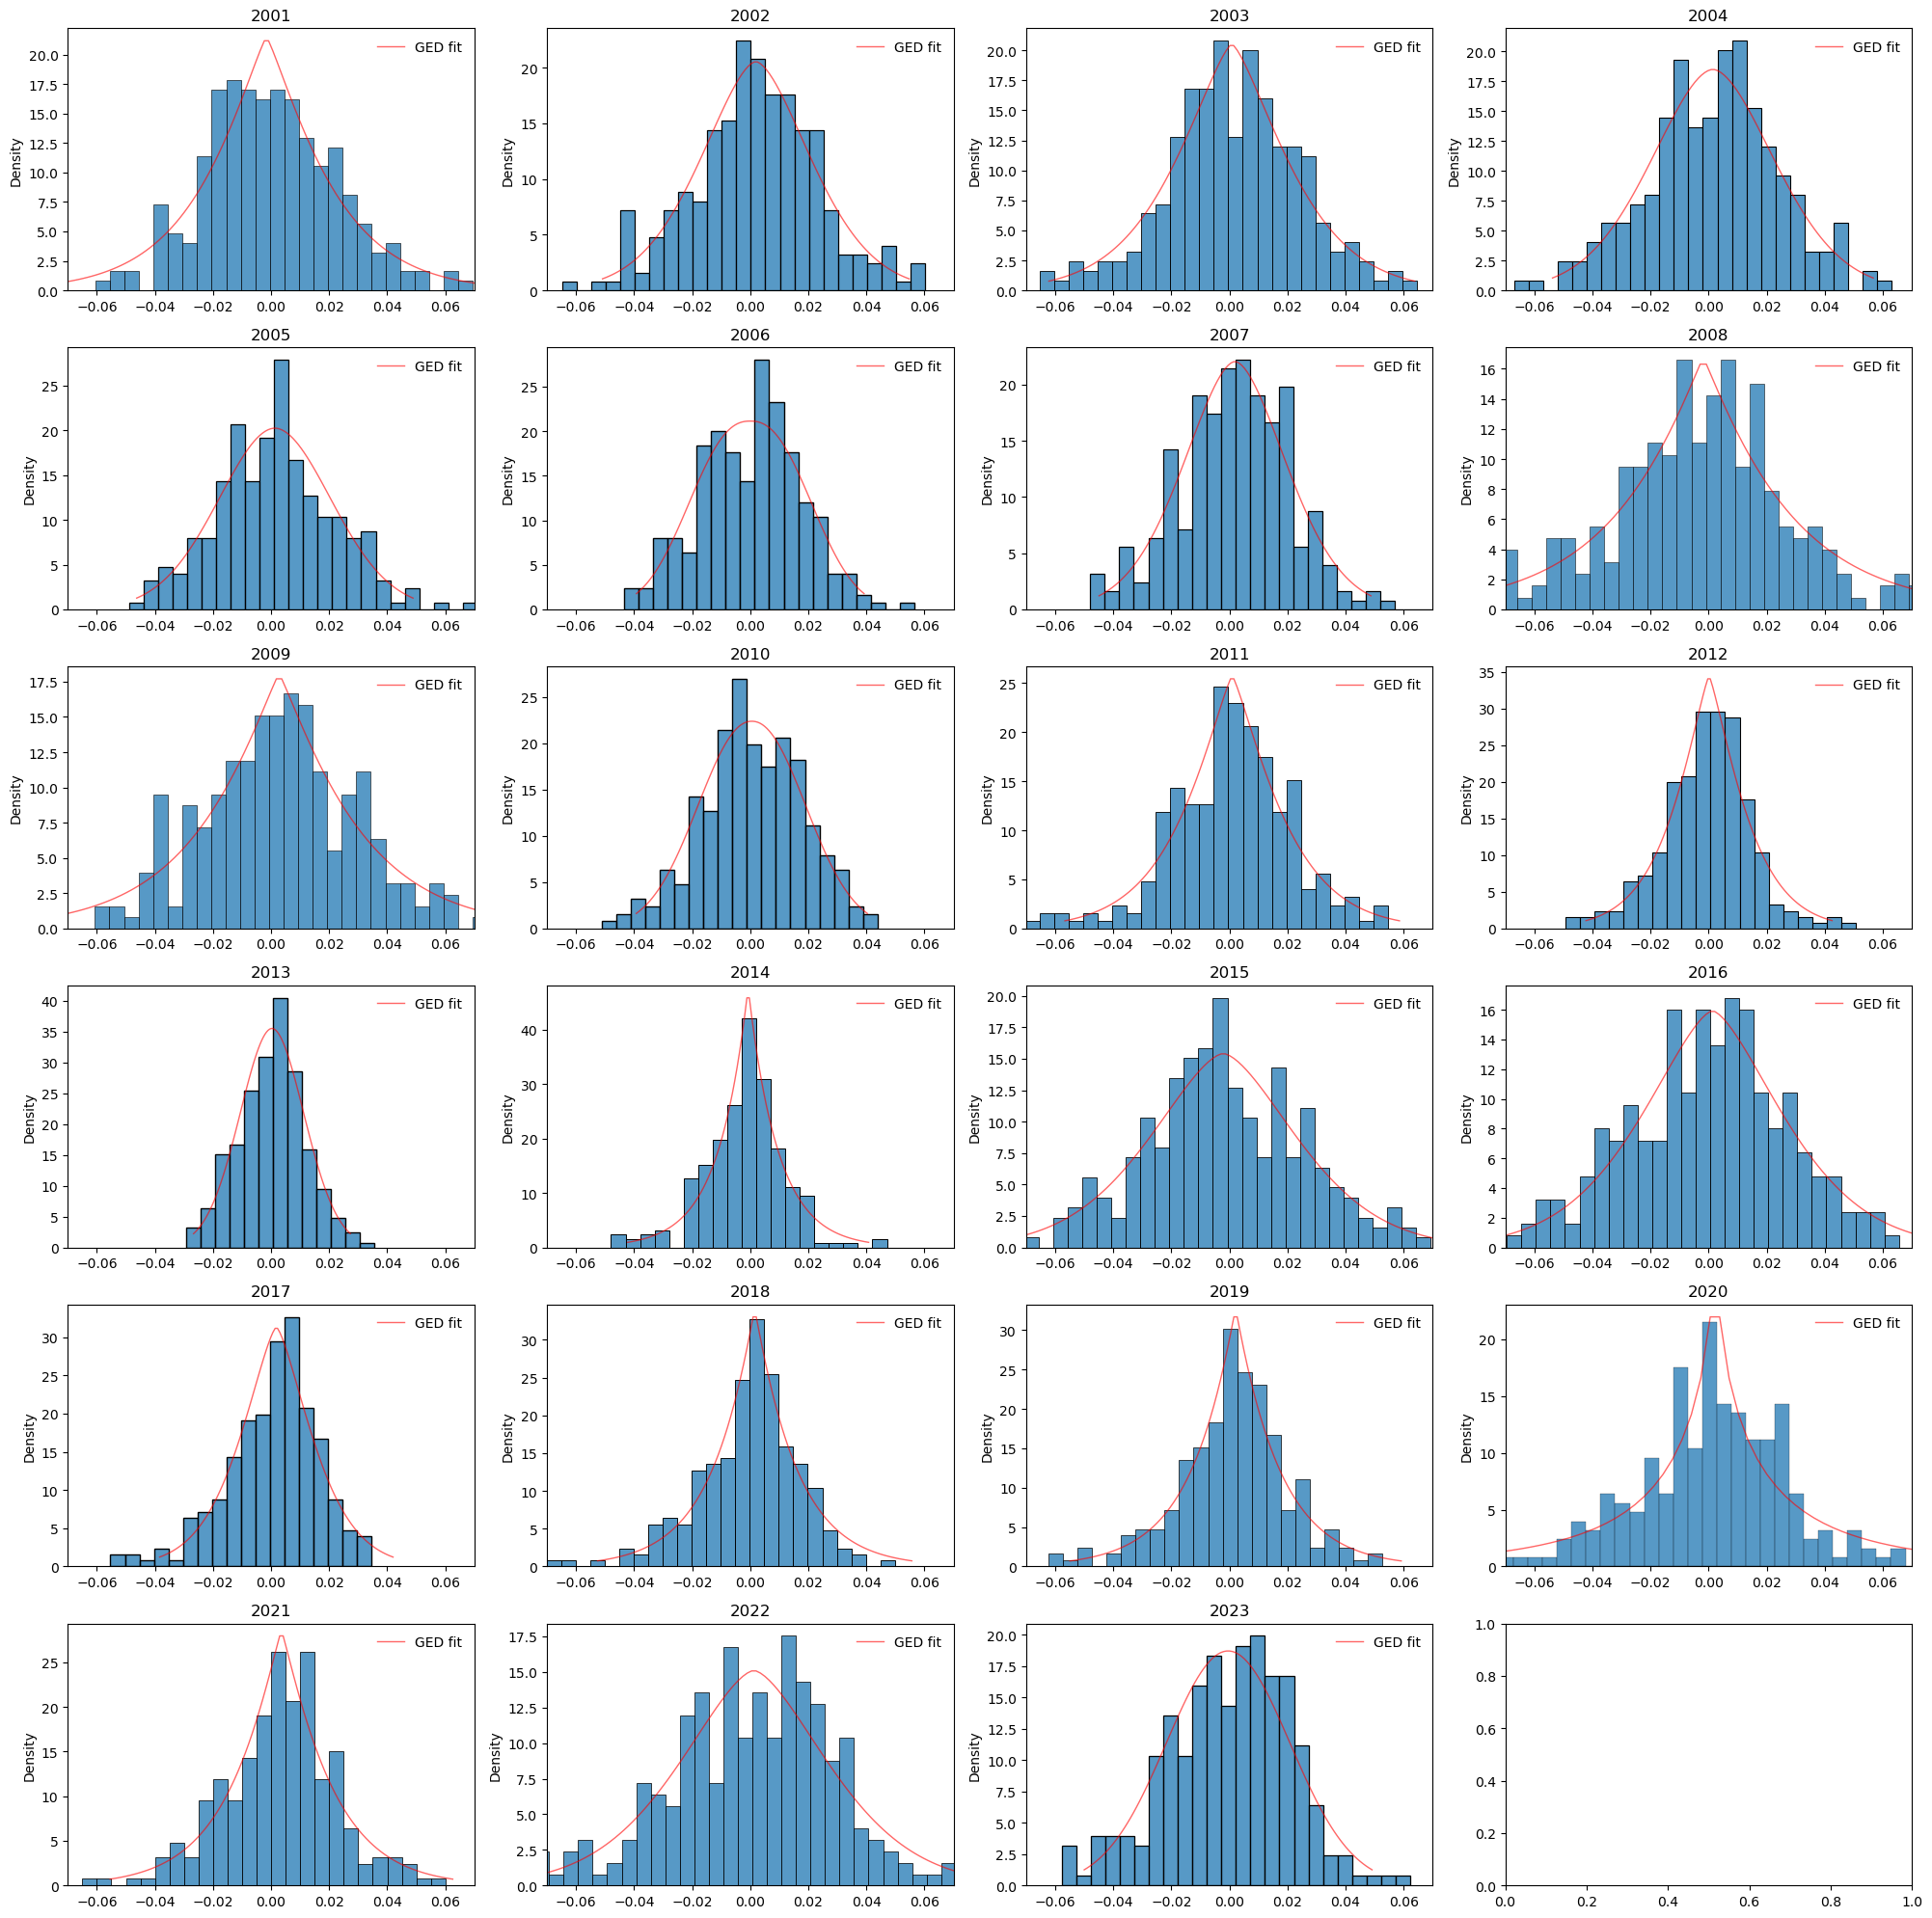

In [6]:
years = range(2001, 2024)
distributions = pd.DataFrame(index=years, columns=['Beta', 'Loc', 'Scale', 
                                                   'Median', 'Mean', 'Std',
                                                   'Log_Likelihood', 'KS_Stat', 'KS_Pval']) 
fig, axs = plt.subplots(nrows=(len(years)+1)//4, ncols=4, figsize=(20, 20))
for i, y in enumerate(years):
    ax = axs[i//4, i%4]
    data = wti.loc[(wti['Year'] == y), 'Log_Return']
    data = np.where((data == np.inf) | (data == -np.inf), np.nan, data)
    data = data[~np.isnan(data)]
    params = gennorm.fit(data)
    log_likelihood = gennorm.logpdf(data, beta=params[0], loc=params[1], scale=params[2]).sum()
    ks_stat, ks_stat_pval = kstest(data, 'gennorm', args=(params[0], params[1], params[2]))
    distributions.loc[y] = [params[0], params[1], params[2],
                            np.median(data), np.mean(data), np.std(data),
                            log_likelihood, ks_stat, ks_stat_pval]

    sns.histplot(data, ax=ax, stat='density', binwidth=0.005)
    x = np.linspace(gennorm.ppf(0.01, params[0], params[1], params[2]), 
                    gennorm.ppf(0.99, params[0], params[1], params[2]), 
                    100)
    ax.plot(x, gennorm.pdf(x, params[0], params[1], params[2]), 'r-', 
                lw=1, alpha=0.6, label='GED fit')
    ax.set(title=y, xlim=(-0.07, 0.07))  
    ax.legend(loc='best', frameon=False)
plt.tight_layout(); plt.show()
    
    

In [7]:
distributions

,Beta,Loc,Scale,Median,Mean,Std,Log_Likelihood,KS_Stat,KS_Pval
2001,1.188616,-0.001591,0.024675,-0.002544,-0.001217,0.02783,549.880705,0.041149,0.781194
2002,1.65396,0.001912,0.027238,0.00152,0.001811,0.021647,604.345704,0.025119,0.996404
2003,1.383877,0.000812,0.026685,0.00099,0.000166,0.024872,574.688157,0.033711,0.929599
2004,1.771764,0.001455,0.030384,0.0031,0.001164,0.02305,585.85025,0.043481,0.717321
2005,1.903645,0.001299,0.027826,0.001321,0.001354,0.020209,623.203314,0.039555,0.812133
2006,2.36811,0.0,0.026706,0.001733,0.000001,0.017522,657.046069,0.046831,0.625968
2007,1.747497,0.001894,0.025435,0.002315,0.001795,0.019471,635.540513,0.030079,0.971409
2008,1.076535,-0.001856,0.030705,-0.001499,-0.003029,0.038955,478.074252,0.037814,0.848632
2009,1.128024,0.002752,0.028906,0.002922,0.002287,0.03421,505.95832,0.027924,0.98638
2010,2.117169,0.00054,0.025207,0.000119,0.00056,0.017332,664.421798,0.037103,0.865513


In [8]:
simulations = pd.DataFrame(index=years, columns=['Sim_Pct_Return', 'Sum_Cum_Return', 'Sim_Prices'])
for y in years[1:]:
    last_price = wti.loc[(wti['Year'] == y-1), 'Close'].iloc[-1]
    log_return = gennorm.rvs(beta=distributions.loc[y-1, 'Beta'], 
                             loc=distributions.loc[y-1, 'Loc'],
                             scale=distributions.loc[y-1, 'Scale'],
                             size=(wti.loc[(wti['Year'] == y), 'Close'].shape[0], 100)) 
    cum_return = np.cumsum(log_return, axis=0)
    sim_prices = last_price * np.exp(cum_return)
    simulations.loc[y] = [log_return, cum_return, sim_prices]
    pass
    

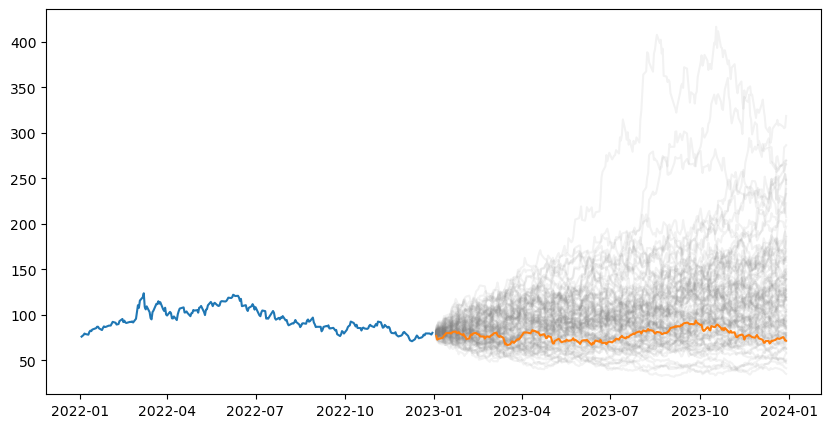

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(wti.loc[(wti['Year'] == 2022), 'Close'], label='Prior Year')
for i in range(100):
    ax.plot(wti.loc[(wti['Year'] == 2023), 'Close'].index, sim_prices[:, i], '-', c='gray', alpha=0.1)
ax.plot(wti.loc[(wti['Year'] == 2023), 'Close'], label='Actual')
plt.show()

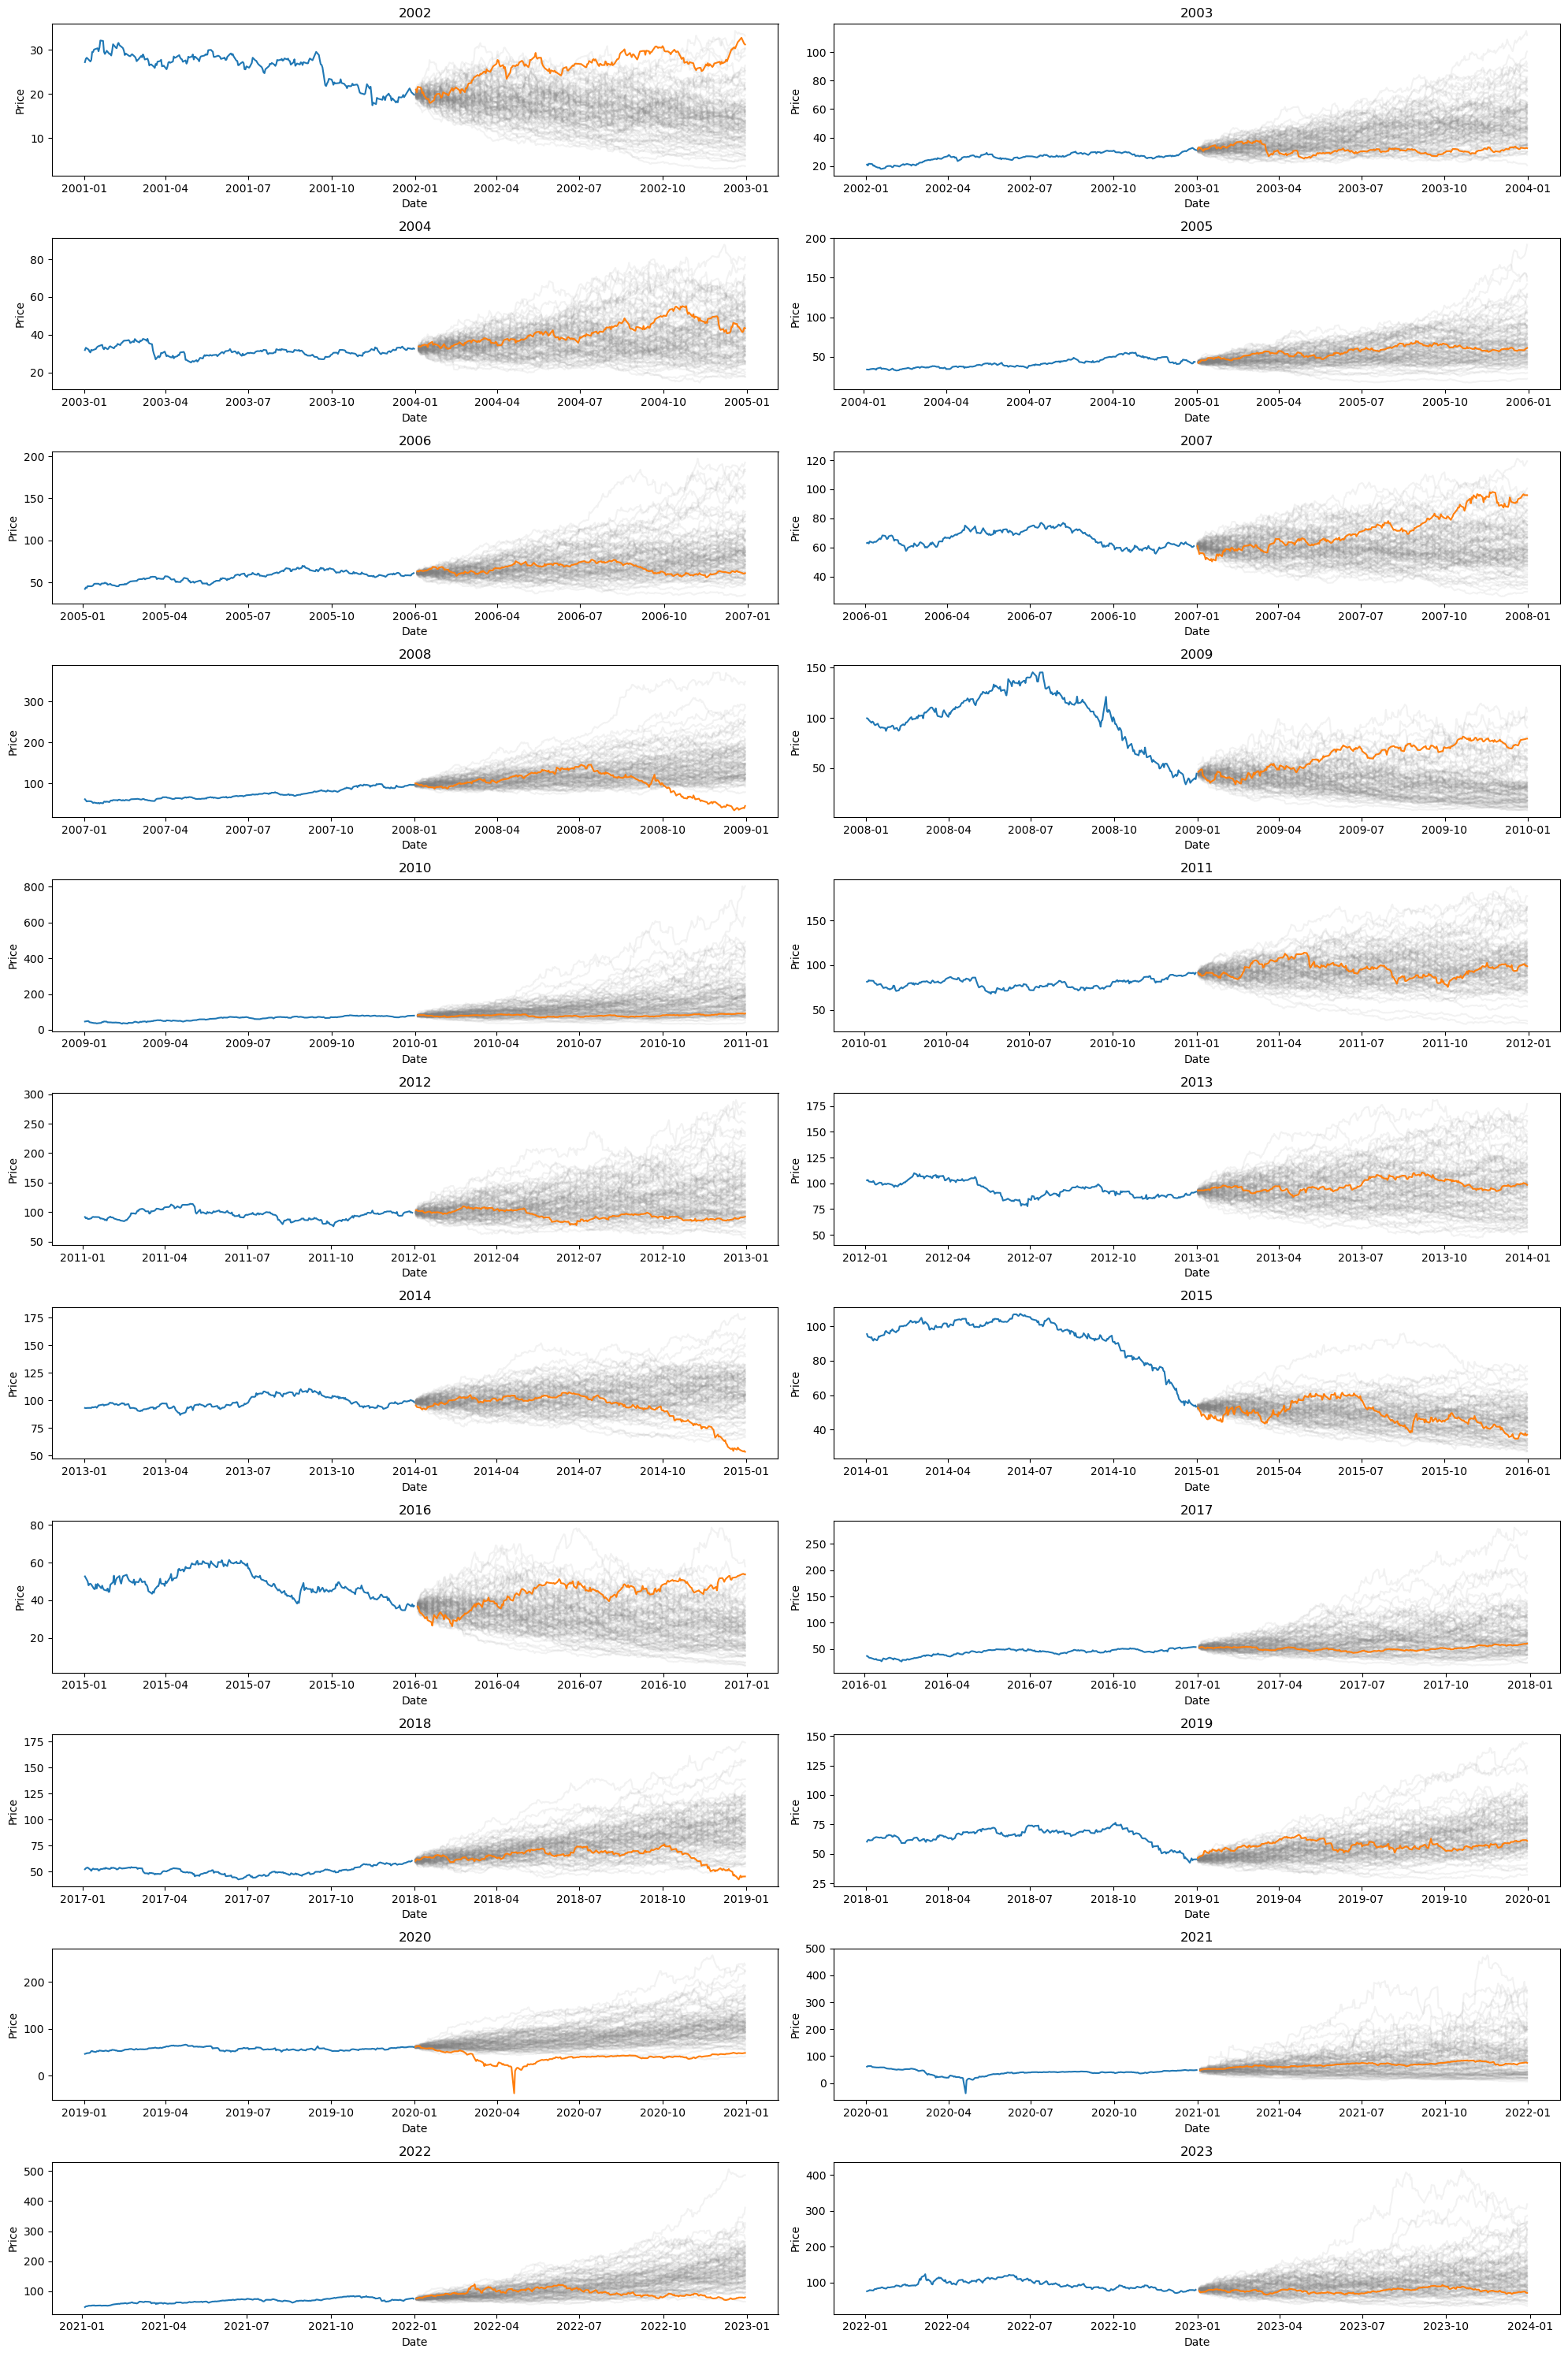

In [10]:
fig, axs = plt.subplots(nrows=(len(years))//2, ncols=2, figsize=(20, 30))
for i, y in enumerate(years[1:]):
    ax = axs[i//2, i%2]
    ax.plot(wti.loc[(wti['Year'] == y-1), 'Close'], label='Prior Year')
    for i in range(100):
        ax.plot(wti.loc[(wti['Year'] == y), 'Close'].index, simulations.loc[y, 'Sim_Prices'][:, i], '-', c='gray', alpha=0.1)
    ax.plot(wti.loc[(wti['Year'] == y), 'Close'], label='Actual')
    ax.set(title=y, xlabel='Date', ylabel='Price')
plt.tight_layout(); plt.show()

In [15]:
confidence_intervals = [10, 20, 30, 40, 50, 60, 70, 80, 90]
ci_scores = pd.DataFrame(index=years, columns=confidence_intervals)
for y in years[1:]:
    actual = wti.loc[(wti['Year'] == y), 'Close']
    trading_days = actual.shape[0]
    sim_prices = simulations.loc[y, 'Sim_Prices']
    scores = []
    for ci in confidence_intervals:
        lower_bound = np.percentile(sim_prices, 50 - (ci / 2), axis=1)
        upper_bound = np.percentile(sim_prices, 50 + (ci / 2), axis=1)
        score = np.logical_and(lower_bound < actual, actual < upper_bound).sum() / trading_days
        scores.append(score)
    ci_scores.loc[y] = scores


In [18]:
ci_scores

,10,20,30,40,50,60,70,80,90
2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002,0.012,0.024,0.036,0.068,0.088,0.124,0.152,0.156,0.228
2003,0.024,0.044,0.076,0.1,0.152,0.188,0.284,0.576,0.928
2004,0.116466,0.248996,0.401606,0.550201,0.706827,0.831325,0.959839,0.991968,1.0
2005,0.199203,0.410359,0.621514,0.721116,0.816733,0.880478,0.936255,0.98008,0.996016
2006,0.2,0.424,0.504,0.56,0.608,0.656,0.804,0.944,0.988
2007,0.055556,0.162698,0.246032,0.333333,0.388889,0.456349,0.563492,0.646825,0.84127
2008,0.110672,0.185771,0.296443,0.383399,0.458498,0.600791,0.652174,0.683794,0.73913
2009,0.019841,0.06746,0.115079,0.115079,0.142857,0.194444,0.257937,0.329365,0.603175
2010,0.003968,0.007937,0.031746,0.087302,0.202381,0.297619,0.56746,0.968254,1.0


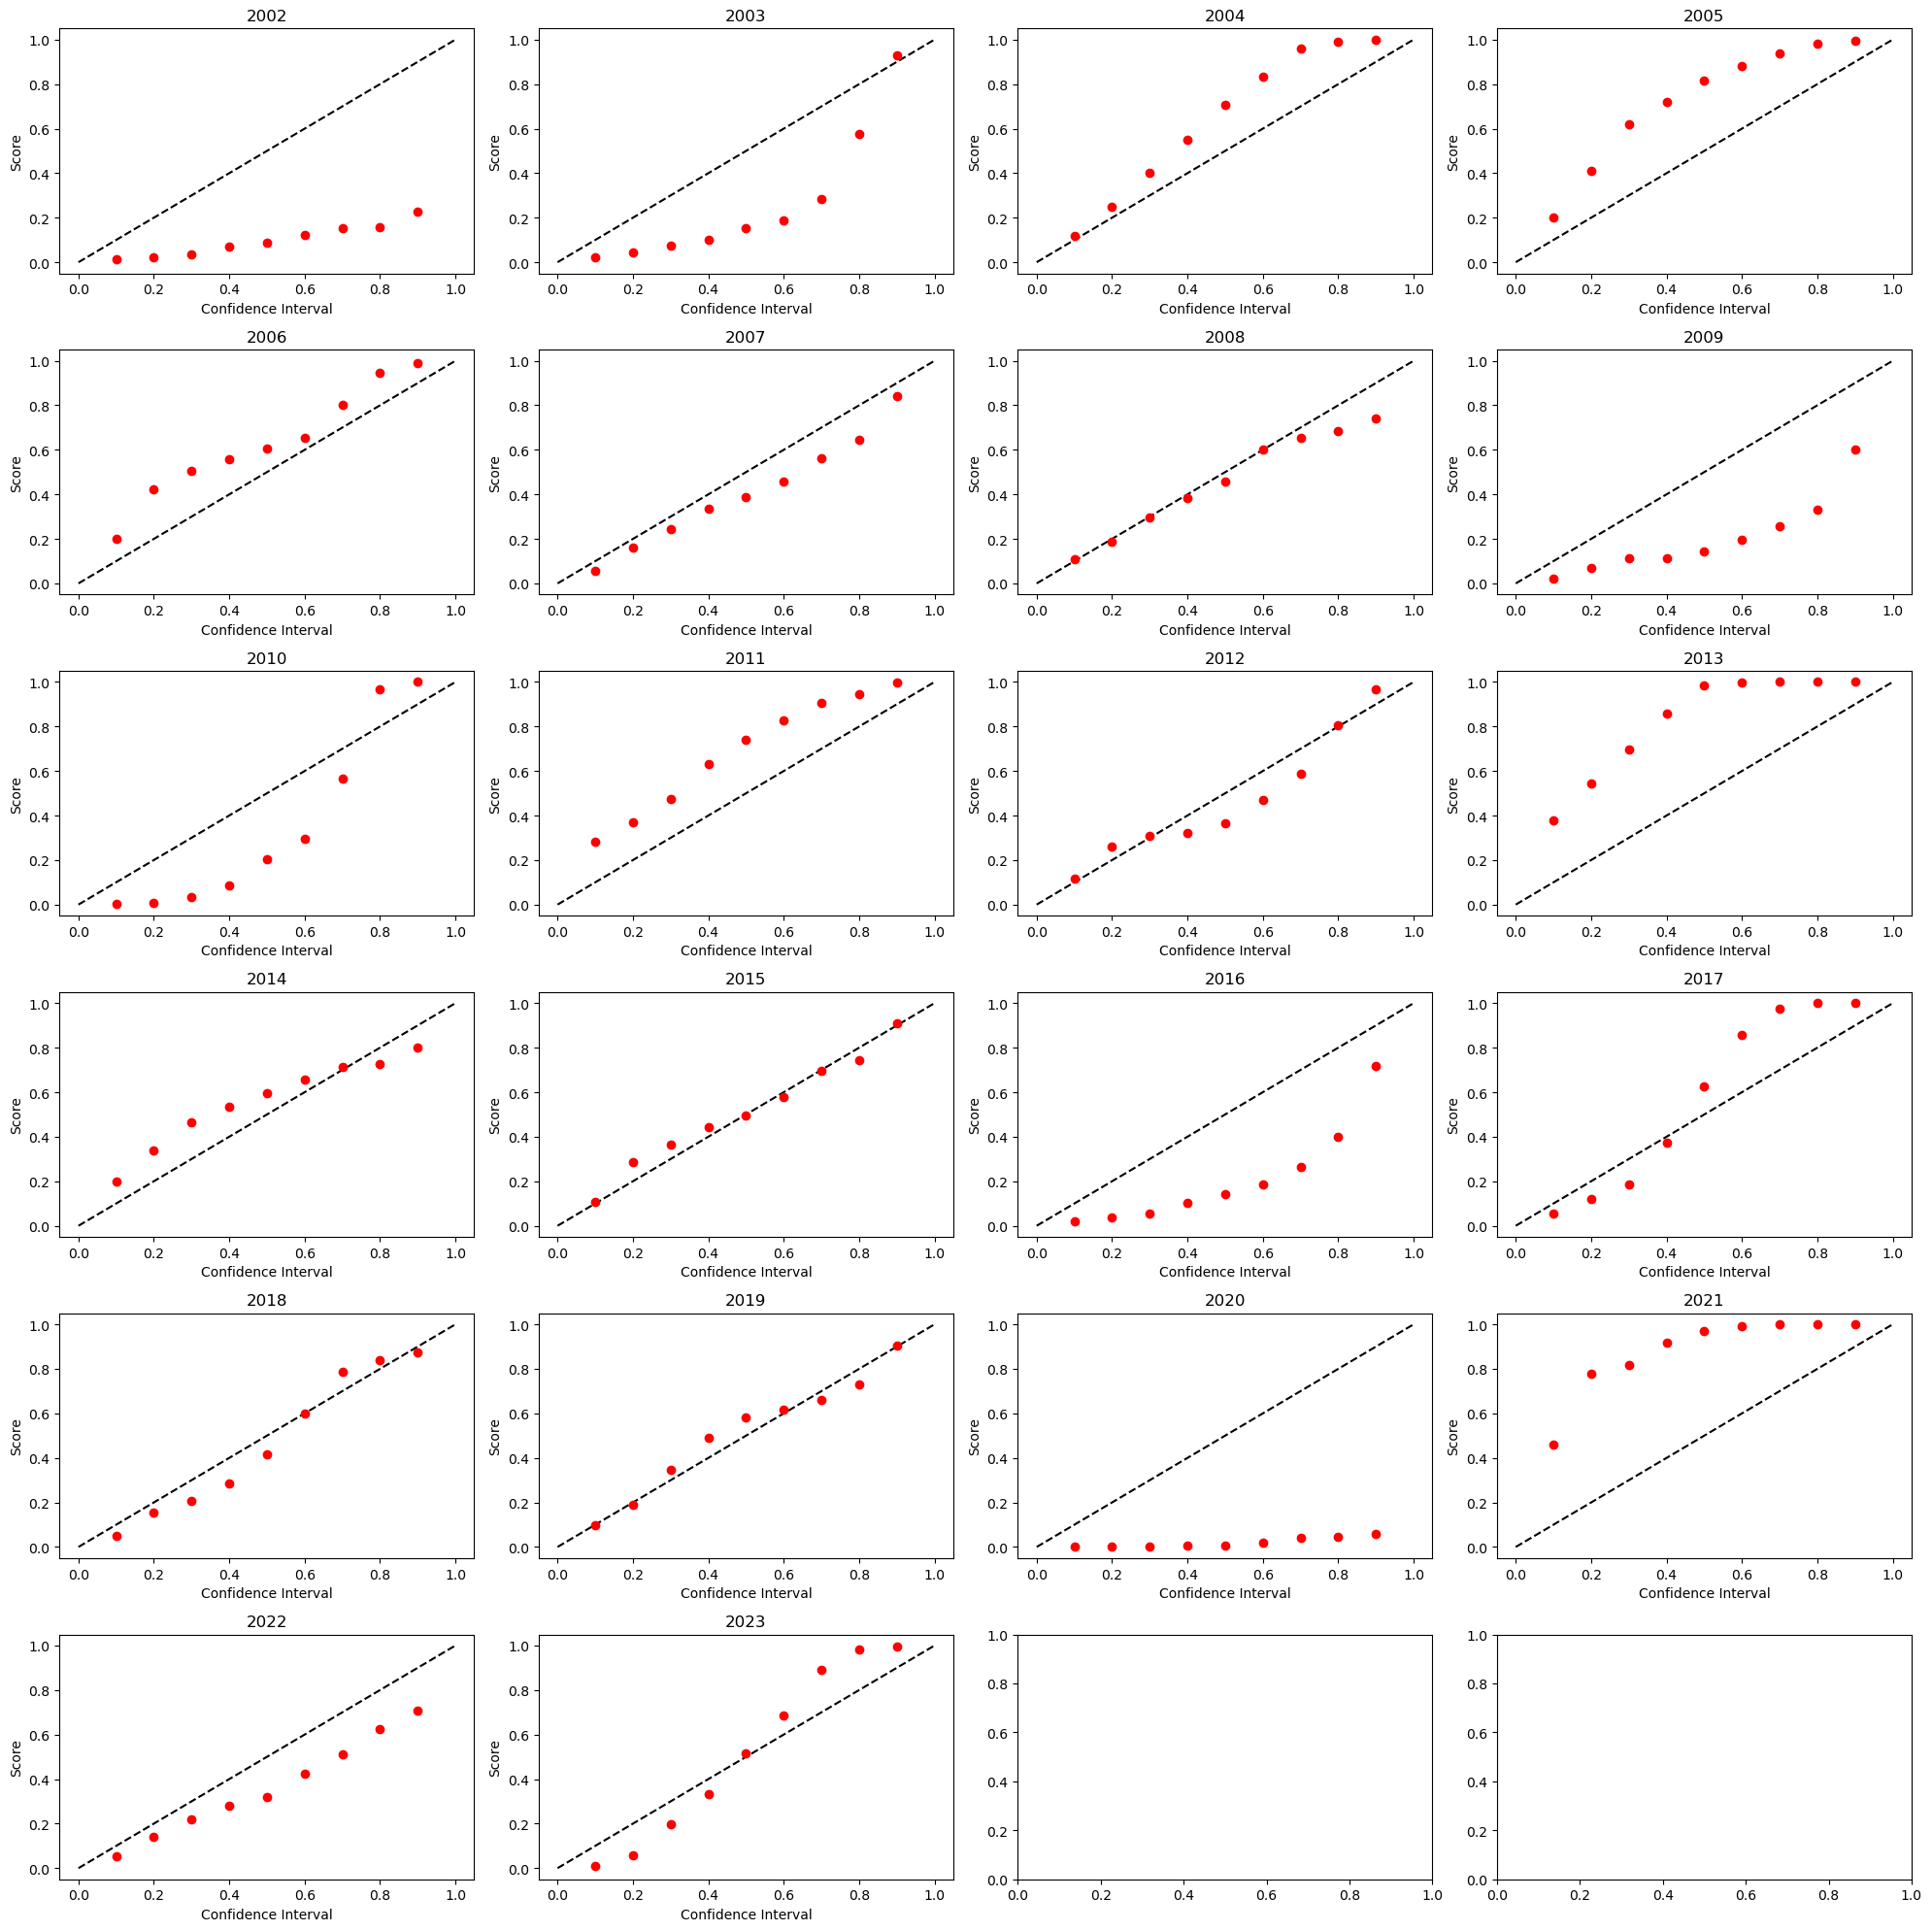

In [22]:
fig, axs = plt.subplots(nrows=(len(ci_scores)+1)//4, ncols=4, figsize=(20, 20))
for i, y in enumerate(years[1:]):
    ax = axs[i//4, i%4]
    ax.plot((0,1), (0,1), 'k--')
    ax.plot(np.array(confidence_intervals) / 100, ci_scores.loc[y], 'ro')
    ax.set(title=y, xlabel='Confidence Interval', ylabel='Score')
plt.tight_layout(); plt.show()
    